In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import dlib
from serpapi import GoogleSearch
from bs4 import BeautifulSoup as bs
import requests

GoogleSearch.SERP_API_KEY = "6a4980a33ed03555f5ca52b26074516509917070cb21fadedefb51e0e573f407"

# 1️⃣ Extracting Data

In [ ]:
params = {
    'q': 'faces',
    'hl': 'en',
    'gl': 'us',
    'safe': 'off',
    'api_key': GoogleSearch.SERP_API_KEY,
    'tbm': 'isch',
    'asyn': 'false',
    'output': 'json'
}

search = GoogleSearch(params)

In [ ]:
result = search.get_dict()

if result['search_metadata']['status'] == 'Success':
    images = []

    for i in range(0, 10):
        imgURL = result['images_results'][i]['original']
        name = result['images_results'][i]['title']

        invalid_characters = ['|', '<', '>', ':', '"', '/', '\\', '?', '*', '.com', '    ', '   ', '  ']
        
        for char in invalid_characters:
            name = name.replace(char, " ")
        name = " ".join(name.strip().split(" "))
        name = name[:160] if len(name) > 160 else name[:]

        if imgURL.startswith("https"):
            try:
                response = requests.get(imgURL)
                if response.status_code == 200:
                    content = response.content
                    img_type = response.headers.get("Content-Type", "").split("/")[-1]
                    try:
                        with open(f'Images/{name}.{img_type}', 'xb') as handler:
                            handler.write(content)
                            images.append(f'{name+'.'+img_type}')
                    except:
                        print(f"'{name+'.'+img_type}' already exists\n\tImage URL: {imgURL}")
                else:
                    print(f"Response code isn't 200 <{response.status_code}>\n\t{imgURL}")
            except Exception as e:
                print(result['images_results'][i]['position'], end='- ')
                print(f"An unexpected error occurred: {e}")
        else:
            print(f"Not https based connection\n\t{imgURL}")

# 2️⃣ Face Detection

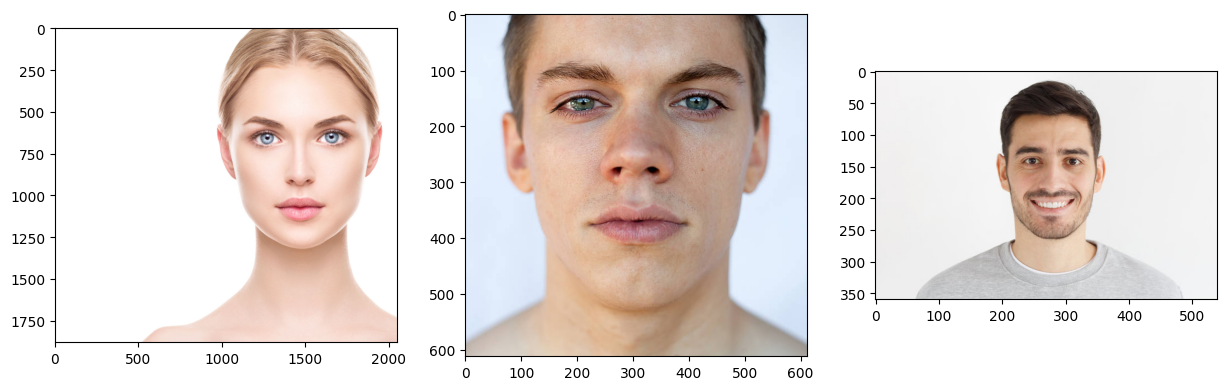

In [28]:
# loading the 3 images only

fig, ax = plt.subplots(1,3)
fig.set_size_inches((15,5))

img_names = ["What Makes a Face Attractive.jpg",
          "Frontal Portrait Young Man.jpg",
          "Potret Siang Hari Closeup Pria Tampan Tersenyum.jpg"]

imgs_content = []

for index, i in enumerate(img_names):
    img = cv2.imread(f"Images\\{i}")
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_content.append(imgRGB)

    ax[index].imshow(imgRGB)

plt.show()

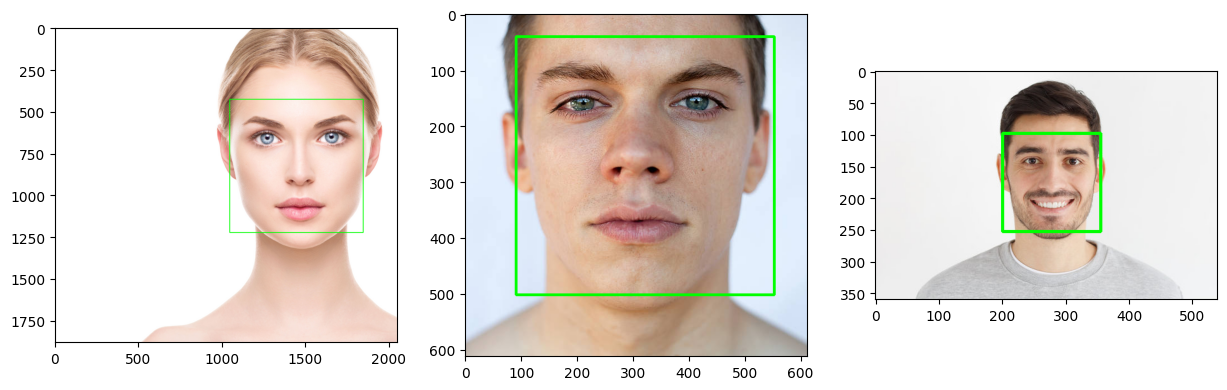

In [39]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

detected_imgs = []

fig, ax = plt.subplots(1,3)
fig.set_size_inches((15,5))

for i, img in enumerate(imgs_content):
    faces = detector(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1)
    temp_img = img.copy()

    for face in faces:
        top_left = (face.tl_corner().x, face.tl_corner().y)
        bottom_right = (face.br_corner().x, face.br_corner().y)

        cv2.rectangle(temp_img, top_left, bottom_right, (0,255,0), thickness=4)

    detected_imgs.append((temp_img, faces))
    ax[i].imshow(temp_img)

plt.show()

## Face Detection
> ### If there is more than one face in the image crop the most left-upper face

Number of detected faces: 6


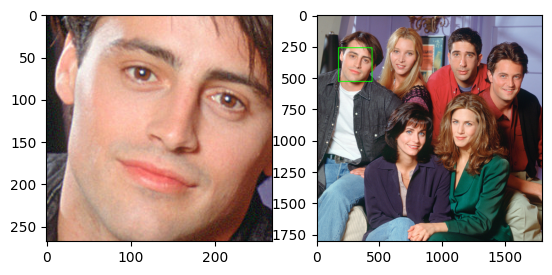

Number of detected faces: 5


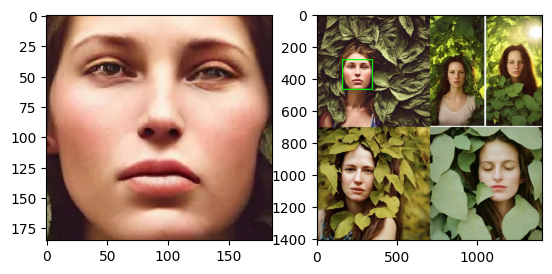

Number of detected faces: 6


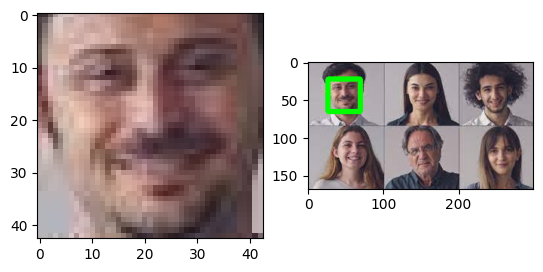

Number of detected faces: 3


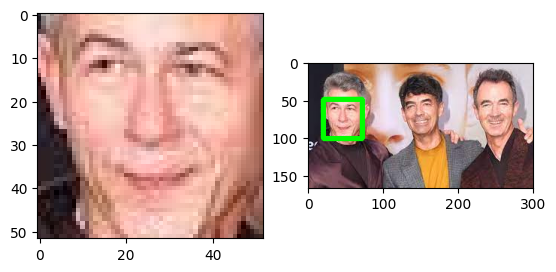

In [37]:
# loading the 4 images with multiple faces
multiple_images = []

for img in ['4.jpg', '5.webp', '6.jpeg', '7.jpeg']:
    multiple_images.append(cv2.cvtColor(cv2.imread(f"Images/{img}"), cv2.COLOR_BGR2RGB))

for i in range(len(multiple_images)):
    rects = detector(multiple_images[i], 1)
    temp_img = multiple_images[i].copy()

    print(f"Number of detected faces: {len(rects)}")
    
    # Calcualte the most left-upper face 
    x = rects[0].tl_corner().x
    y = rects[0].tl_corner().y
    x2 = rects[0].br_corner().x
    y2 = rects[0].br_corner().y
    x_most_tl = x
    y_most_tl = y
    x_most_br = x2
    y_most_br = y2
    for j in range(len(rects)):
        if (rects[j].tl_corner().x <= x_most_tl):
            if (rects[j].tl_corner().y <= y_most_tl) or ((abs(x_most_tl-(rects[j].tl_corner().x)) > (len(temp_img[0]))//10) or (abs(y_most_tl-rects[j].tl_corner().y) < (len(temp_img)//10))):
                x_most_tl = rects[j].tl_corner().x
                y_most_tl = rects[j].tl_corner().y
                x_most_br = rects[j].br_corner().x
                y_most_br = rects[j].br_corner().y

    # Crop to the most upper-left face and Crop to it
    fig, ax = plt.subplots(1,2)

    crop_face = temp_img[y_most_tl:y_most_br , x_most_tl:x_most_br]
    ax[0].imshow(crop_face)

    cv2.rectangle(temp_img, (x_most_tl, y_most_tl), (x_most_br, y_most_br), (0, 255, 0), thickness=5)
    ax[1].imshow(temp_img)

    plt.show()

# 3️⃣ Landmarks
### Crop only eyes region from the image

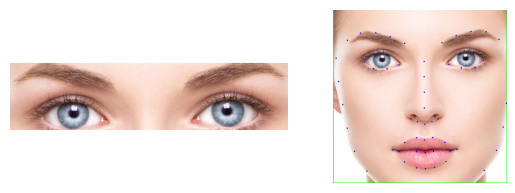

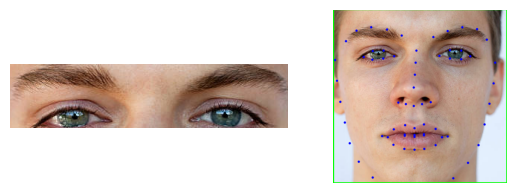

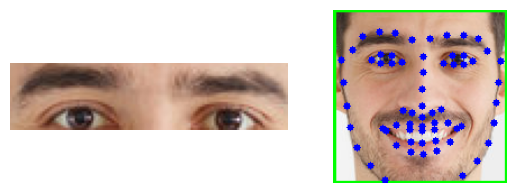

In [98]:
eyes_faces = []

for i, (img, rects) in enumerate(detected_imgs):
    eyes_faces.append([])
    
    for f in rects:
        landmarks = predictor(img, f)
            
        shape_np = np.zeros((68,2), dtype="int")
            
        for j in range(len(shape_np)):
            shape_np[j] = (landmarks.part(j).x, landmarks.part(j).y)
        
        # Draw Landmarks on images and crop the face
        temp = img.copy()
        
        col1 = f.tl_corner().x
        col2 = f.br_corner().x
        row1 = f.tl_corner().y
        row2 = f.br_corner().y
        
        for x,y in shape_np:
            cv2.circle(temp, (x,y), 3, (0,0,255), -1)

        crop_face = temp[row1:row2, col1:col2]
        
        # Crop the Eye Area
        eye_row1 = shape_np[24][1] if shape_np[24][1] < shape_np[19][1] else shape_np[19][1]
        eye_row2 = shape_np[41][1] if shape_np[41][1] > shape_np[46][1] else shape_np[46][1]
        eye_col1 = shape_np[17][0]
        eye_col2 = shape_np[26][0]
        
        crop_eyes = img[eye_row1:eye_row2, eye_col1:eye_col2]
        
        eyes_faces[i].append((crop_eyes, crop_face))

# Visualizing the Cropped Faces and Eyes
for i in range(len(eyes_faces)):
    for j in range(len(eyes_faces[i])):
        fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [8,5]})
        ax[0].imshow(eyes_faces[i][j][0])
        ax[0].axis('off')
        ax[1].imshow(eyes_faces[i][j][1])
        ax[1].axis('off')
        plt.show()

# 4️⃣ Face Censoring

In [3]:
from time import time

video = 'Images/smile.mp4'

def FaceCensoring(vid):
    video = cv2.VideoCapture(vid)
    fbs = video.get(cv2.CAP_PROP_FPS)
    total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    width, height = map(int, (video.get(cv2.CAP_PROP_FRAME_WIDTH), video.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    detection_model = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    output = cv2.VideoWriter("Face Censoring.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fbs, (width, height))

    processing_time = time()

    for i in range(1, int(total_frames+1)):
        success, frame = video.read()
        if not success:
            break

        faces = detection_model.detectMultiScale(frame, 1.1, 6)
        for (x, y, w, h) in faces:
            frame[y:y+h, x:x+w] = cv2.blur(frame[y:y+h, x:x+w], (101, 101))
        output.write(frame)

    processing_time = time() - processing_time

    video.release()
    output.release()

    return processing_time

print("Processing Time (s):", FaceCensoring(video))

Processing Time (s): 28.41451072692871
